# Clasificación de imágenes y explicación con LIME
***
* LIME permite identificar los superpixels de la imagen que contribuyen positiva o negativamente en las predicciones generadas por el clasificador
* Ejemplo basado en [Tutorial LIME: Tutorial - Image Classification Keras.ipynb](https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20Image%20Classification%20Keras.ipynb)

## Bibliotecas

In [1]:
import os
import keras
from keras.applications import inception_v3 as inc_net
#from keras.preprocessing import image
import keras.utils as image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
print('Notebook run using keras:', keras.__version__)

Notebook run using keras: 2.9.0


## Uso de Inception V3
***
* El modelo InceptionV3 preentrenado está disponible en Keras y es usado para clasificación de imágenes y tiene un desempeño de  78,1% de accuracy en el conjunto de datos de ImageNet.
* Para revisar la arquitectura CNN Inceptión, revisar [acá](https://arxiv.org/abs/1512.00567v3)
* La documentación del módulo inception_v3 de Keras, en este [link](https://keras.io/api/applications/inceptionv3/)
* El diagrama de la arquitectura [acá](https://paperswithcode.com/method/inception-v3)

In [2]:
inet_model = inc_net.InceptionV3()

2023-08-17 11:01:38.652178: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


* Transformación de la imagen al formato y dimensión requeridas

In [3]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

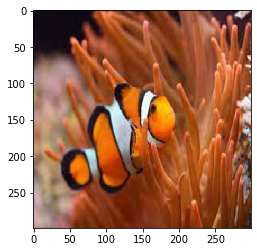

In [4]:
images = transform_img_fn([os.path.join('data','anemone.jpg')])
plt.figure()
plt.imshow(images[0] / 2 + 0.5)
#plt.imshow(images[0])
plt.show()


## Predicción en la imagen de prueba

In [5]:
preds = inet_model.predict(images) # vector de tamaño 1000

1/1 [==============================] - 2s 2s/step


Se muestran los primeros 6 puntajes de clasificación, y se observa que "anemone fish" es la primera predicción para la imagen, con un puntaje de 0.71

In [6]:
for x in decode_predictions(preds,top=6)[0]:
    print("Predicción clase: ",x[1], "con puntaje: ",x[2])

Predicción clase:  anemone_fish con puntaje:  0.714063
Predicción clase:  sea_anemone con puntaje:  0.19297479
Predicción clase:  coral_reef con puntaje:  0.011119976
Predicción clase:  rock_beauty con puntaje:  0.00086222915
Predicción clase:  scuba_diver con puntaje:  0.000687733
Predicción clase:  sea_urchin con puntaje:  0.000558448


In [7]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) 
    import lime
from lime import lime_image

/Users/rpezoa/opt/anaconda3/envs/higgs/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Explicación usando LimeImageExplainer()
***
[Documentación](https://lime-ml.readthedocs.io/en/latest/lime.html?highlight=submodular_pick#module-lime.lime_image) de lime_image.

In [8]:
explainer = lime_image.LimeImageExplainer()

In [9]:
%%time
# Hide color is the color for a superpixel turned OFF. 
# Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(images[0].astype('double'), 
                                         inet_model.predict, 
                                         top_labels=6, 
                                         hide_color=0, 
                                         num_samples=1000)

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


  1%|▍                                        | 10/1000 [00:01<02:14,  7.34it/s]

1/1 [==============================] - 1s 1s/step


  2%|▊                                        | 20/1000 [00:02<02:05,  7.79it/s]

1/1 [==============================] - 1s 1s/step


  4%|█▌                                       | 39/1000 [00:03<01:20, 11.94it/s]

1/1 [==============================] - 1s 1s/step


  4%|█▊                                       | 43/1000 [00:05<01:58,  8.10it/s]

1/1 [==============================] - 1s 1s/step


  5%|██                                       | 50/1000 [00:06<02:12,  7.18it/s]

1/1 [==============================] - 1s 1s/step


  6%|██▍                                      | 60/1000 [00:07<02:05,  7.47it/s]

1/1 [==============================] - 1s 1s/step


  7%|██▊                                      | 70/1000 [00:08<02:00,  7.70it/s]

1/1 [==============================] - 1s 1s/step


  8%|███▎                                     | 80/1000 [00:10<01:56,  7.89it/s]

1/1 [==============================] - 2s 2s/step


 10%|████                                     | 98/1000 [00:11<01:37,  9.28it/s]

1/1 [==============================] - 1s 1s/step


 10%|████                                    | 102/1000 [00:13<02:13,  6.71it/s]

1/1 [==============================] - 1s 1s/step


 11%|████▍                                   | 110/1000 [00:14<02:19,  6.36it/s]

1/1 [==============================] - 1s 1s/step


 12%|████▊                                   | 120/1000 [00:16<02:19,  6.32it/s]

1/1 [==============================] - 1s 1s/step


 13%|█████▏                                  | 130/1000 [00:17<02:19,  6.26it/s]

1/1 [==============================] - 1s 1s/step


 14%|█████▌                                  | 140/1000 [00:19<02:10,  6.60it/s]

1/1 [==============================] - 1s 1s/step


 15%|██████                                  | 150/1000 [00:20<02:00,  7.04it/s]

1/1 [==============================] - 1s 1s/step


 16%|██████▍                                 | 160/1000 [00:22<02:01,  6.90it/s]

1/1 [==============================] - 1s 1s/step


 17%|██████▊                                 | 170/1000 [00:23<01:54,  7.25it/s]

1/1 [==============================] - 1s 1s/step


 18%|███████▏                                | 180/1000 [00:24<01:48,  7.52it/s]

1/1 [==============================] - 1s 1s/step


 19%|███████▌                                | 190/1000 [00:25<01:45,  7.66it/s]

1/1 [==============================] - 1s 1s/step


 20%|████████                                | 200/1000 [00:26<01:42,  7.78it/s]

1/1 [==============================] - 1s 1s/step


 21%|████████▍                               | 210/1000 [00:28<01:40,  7.84it/s]

1/1 [==============================] - 1s 1s/step


 22%|████████▊                               | 220/1000 [00:29<01:38,  7.93it/s]

1/1 [==============================] - 1s 1s/step


 23%|█████████▏                              | 230/1000 [00:30<01:35,  8.03it/s]

1/1 [==============================] - 1s 1s/step


 24%|█████████▌                              | 240/1000 [00:31<01:34,  8.08it/s]

1/1 [==============================] - 1s 1s/step


 25%|██████████                              | 250/1000 [00:33<01:32,  8.14it/s]

1/1 [==============================] - 1s 1s/step


 26%|██████████▍                             | 260/1000 [00:34<01:30,  8.18it/s]

1/1 [==============================] - 1s 1s/step


 27%|██████████▊                             | 270/1000 [00:35<01:29,  8.20it/s]

1/1 [==============================] - 1s 1s/step


 28%|███████████▏                            | 280/1000 [00:36<01:27,  8.20it/s]

1/1 [==============================] - 1s 1s/step


 29%|███████████▌                            | 290/1000 [00:37<01:26,  8.24it/s]

1/1 [==============================] - 1s 1s/step


 30%|████████████                            | 300/1000 [00:39<01:25,  8.22it/s]

1/1 [==============================] - 1s 1s/step


 31%|████████████▍                           | 310/1000 [00:40<01:23,  8.23it/s]

1/1 [==============================] - 1s 1s/step


 32%|████████████▊                           | 320/1000 [00:41<01:27,  7.80it/s]

1/1 [==============================] - 2s 2s/step


 34%|█████████████▌                          | 339/1000 [00:43<01:15,  8.81it/s]

1/1 [==============================] - 2s 2s/step


 35%|█████████████▉                          | 348/1000 [00:46<01:33,  6.96it/s]

1/1 [==============================] - 1s 1s/step


 35%|██████████████                          | 352/1000 [00:47<02:01,  5.32it/s]

1/1 [==============================] - 1s 1s/step


 37%|██████████████▋                         | 367/1000 [00:49<01:25,  7.39it/s]

1/1 [==============================] - 1s 1s/step


 37%|██████████████▊                         | 371/1000 [00:50<01:45,  5.94it/s]

1/1 [==============================] - 1s 1s/step


 38%|███████████████▏                        | 380/1000 [00:52<01:44,  5.93it/s]

1/1 [==============================] - 1s 1s/step


 40%|███████████████▊                        | 395/1000 [00:53<01:21,  7.40it/s]

1/1 [==============================] - 1s 1s/step


 41%|████████████████▎                       | 409/1000 [00:55<01:03,  9.24it/s]

1/1 [==============================] - 2s 2s/step


 41%|████████████████▌                       | 413/1000 [00:57<01:48,  5.40it/s]

1/1 [==============================] - 1s 1s/step


 43%|█████████████████                       | 427/1000 [00:58<01:19,  7.17it/s]

1/1 [==============================] - 1s 1s/step


 43%|█████████████████▏                      | 431/1000 [01:00<01:39,  5.70it/s]

1/1 [==============================] - 2s 2s/step


 44%|█████████████████▌                      | 440/1000 [01:01<01:41,  5.53it/s]

1/1 [==============================] - 1s 1s/step


 45%|██████████████████                      | 450/1000 [01:03<01:30,  6.05it/s]

1/1 [==============================] - 2s 2s/step


 46%|██████████████████▍                     | 460/1000 [01:05<01:32,  5.81it/s]

1/1 [==============================] - 1s 1s/step


 48%|███████████████████                     | 476/1000 [01:06<01:08,  7.67it/s]

1/1 [==============================] - 2s 2s/step


 48%|███████████████████▏                    | 480/1000 [01:08<01:43,  5.02it/s]

1/1 [==============================] - 1s 1s/step


 50%|███████████████████▉                    | 499/1000 [01:10<00:58,  8.52it/s]

1/1 [==============================] - 2s 2s/step


 50%|████████████████████                    | 502/1000 [01:12<01:47,  4.62it/s]

1/1 [==============================] - 2s 2s/step


 51%|████████████████████▍                   | 510/1000 [01:14<01:57,  4.18it/s]

1/1 [==============================] - 1s 1s/step


 53%|█████████████████████▏                  | 529/1000 [01:16<01:01,  7.70it/s]

1/1 [==============================] - 1s 1s/step


 53%|█████████████████████▎                  | 533/1000 [01:17<01:15,  6.22it/s]

1/1 [==============================] - 1s 1s/step


 54%|█████████████████████▌                  | 540/1000 [01:18<01:16,  6.00it/s]

1/1 [==============================] - 1s 1s/step


 56%|██████████████████████▎                 | 559/1000 [01:20<00:48,  9.10it/s]

1/1 [==============================] - 2s 2s/step


 57%|██████████████████████▋                 | 568/1000 [01:21<00:57,  7.46it/s]

1/1 [==============================] - 2s 2s/step


 57%|██████████████████████▉                 | 572/1000 [01:23<01:29,  4.79it/s]

1/1 [==============================] - 1s 1s/step


 58%|███████████████████████▏                | 580/1000 [01:25<01:26,  4.88it/s]

1/1 [==============================] - 1s 1s/step


 60%|███████████████████████▉                | 597/1000 [01:26<00:52,  7.62it/s]

1/1 [==============================] - 1s 1s/step


 60%|████████████████████████                | 601/1000 [01:28<01:05,  6.11it/s]

1/1 [==============================] - 1s 1s/step


 61%|████████████████████████▍               | 610/1000 [01:29<01:00,  6.46it/s]

1/1 [==============================] - 1s 1s/step


 62%|████████████████████████▊               | 620/1000 [01:30<00:54,  6.93it/s]

1/1 [==============================] - 2s 2s/step


 64%|█████████████████████████▍              | 635/1000 [01:33<00:52,  6.95it/s]

1/1 [==============================] - 1s 1s/step


 64%|█████████████████████████▌              | 640/1000 [01:34<01:00,  5.93it/s]

1/1 [==============================] - 2s 2s/step


 66%|██████████████████████████▎             | 659/1000 [01:36<00:40,  8.35it/s]

1/1 [==============================] - 1s 1s/step


 66%|██████████████████████████▌             | 663/1000 [01:37<00:51,  6.58it/s]

1/1 [==============================] - 1s 1s/step


 67%|██████████████████████████▊             | 670/1000 [01:38<00:52,  6.28it/s]

1/1 [==============================] - 1s 1s/step


 68%|███████████████████████████▏            | 680/1000 [01:40<00:46,  6.88it/s]

1/1 [==============================] - 1s 1s/step


 69%|███████████████████████████▌            | 690/1000 [01:41<00:43,  7.18it/s]

1/1 [==============================] - 1s 1s/step


 70%|████████████████████████████            | 700/1000 [01:42<00:40,  7.35it/s]

1/1 [==============================] - 1s 1s/step


 72%|████████████████████████████▋           | 718/1000 [01:43<00:28, 10.06it/s]

1/1 [==============================] - 1s 1s/step


 72%|████████████████████████████▉           | 722/1000 [01:45<00:36,  7.66it/s]

1/1 [==============================] - 1s 1s/step


 73%|█████████████████████████████▏          | 730/1000 [01:46<00:36,  7.31it/s]

1/1 [==============================] - 1s 1s/step


 74%|█████████████████████████████▌          | 740/1000 [01:47<00:34,  7.58it/s]

1/1 [==============================] - 1s 1s/step


 75%|██████████████████████████████          | 750/1000 [01:48<00:32,  7.76it/s]

1/1 [==============================] - 1s 1s/step


 76%|██████████████████████████████▍         | 760/1000 [01:50<00:30,  7.84it/s]

1/1 [==============================] - 1s 1s/step


 77%|██████████████████████████████▊         | 770/1000 [01:51<00:28,  7.94it/s]

1/1 [==============================] - 1s 1s/step


 78%|███████████████████████████████▏        | 780/1000 [01:52<00:27,  7.99it/s]

1/1 [==============================] - 1s 1s/step


 79%|███████████████████████████████▌        | 790/1000 [01:53<00:26,  8.03it/s]

1/1 [==============================] - 1s 1s/step


 80%|████████████████████████████████        | 800/1000 [01:54<00:24,  8.02it/s]

1/1 [==============================] - 1s 1s/step


 81%|████████████████████████████████▍       | 810/1000 [01:56<00:23,  8.03it/s]

1/1 [==============================] - 1s 1s/step


 83%|█████████████████████████████████▏      | 829/1000 [01:57<00:15, 10.81it/s]

1/1 [==============================] - 1s 1s/step


 83%|█████████████████████████████████▎      | 833/1000 [01:58<00:20,  8.13it/s]

1/1 [==============================] - 1s 1s/step


 84%|█████████████████████████████████▌      | 840/1000 [01:59<00:22,  7.25it/s]

1/1 [==============================] - 1s 1s/step


 85%|██████████████████████████████████      | 850/1000 [02:01<00:20,  7.44it/s]

1/1 [==============================] - 1s 1s/step


 86%|██████████████████████████████████▍     | 860/1000 [02:02<00:18,  7.67it/s]

1/1 [==============================] - 1s 1s/step


 87%|██████████████████████████████████▊     | 870/1000 [02:03<00:16,  7.77it/s]

1/1 [==============================] - 1s 1s/step


 88%|███████████████████████████████████▏    | 880/1000 [02:04<00:15,  7.85it/s]

1/1 [==============================] - 2s 2s/step


 90%|███████████████████████████████████▉    | 897/1000 [02:06<00:11,  8.84it/s]

1/1 [==============================] - 2s 2s/step


 90%|████████████████████████████████████    | 900/1000 [02:08<00:17,  5.84it/s]

1/1 [==============================] - 1s 1s/step


 91%|████████████████████████████████████▍   | 910/1000 [02:09<00:13,  6.56it/s]

1/1 [==============================] - 1s 1s/step


 92%|████████████████████████████████████▊   | 920/1000 [02:11<00:12,  6.60it/s]

1/1 [==============================] - 1s 1s/step


 93%|█████████████████████████████████████▏  | 930/1000 [02:12<00:10,  6.77it/s]

1/1 [==============================] - 1s 1s/step


 94%|█████████████████████████████████████▌  | 940/1000 [02:13<00:08,  7.12it/s]

1/1 [==============================] - 1s 1s/step


 95%|██████████████████████████████████████  | 950/1000 [02:15<00:07,  7.01it/s]

1/1 [==============================] - 1s 1s/step


 96%|██████████████████████████████████████▍ | 960/1000 [02:16<00:05,  7.07it/s]

1/1 [==============================] - 1s 1s/step


 97%|██████████████████████████████████████▊ | 970/1000 [02:18<00:04,  7.36it/s]

1/1 [==============================] - 1s 1s/step


 98%|███████████████████████████████████████▏| 980/1000 [02:19<00:02,  7.59it/s]

1/1 [==============================] - 1s 1s/step


 99%|███████████████████████████████████████▌| 990/1000 [02:20<00:01,  7.78it/s]

1/1 [==============================] - 1s 1s/step


100%|███████████████████████████████████████| 1000/1000 [02:21<00:00,  7.06it/s]

CPU times: user 6min 9s, sys: 31.2 s, total: 6min 40s
Wall time: 2min 23s


## Segmentos o superpíxeles generados

In [10]:
explanation.segments.max()

65

In [11]:
explanation.segments

array([[ 3,  3,  3, ...,  5,  5,  5],
       [ 3,  3,  3, ...,  5,  5,  5],
       [ 3,  3,  3, ...,  5,  5,  5],
       ...,
       [64, 64, 64, ..., 59, 59, 59],
       [64, 64, 64, ..., 59, 59, 59],
       [64, 64, 64, ..., 59, 59, 59]])

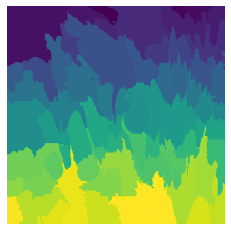

In [12]:
plt.imshow(explanation.segments)
plt.axis('off')
plt.show()

## Visualización de los superpíxeles que contribuyen a la predicción
***
* Uso de módulo [scikit-image](https://scikit-image.org), el cual provee un gran número de algoritmos para procesamiento de imágenes

In [13]:
from skimage.segmentation import mark_boundaries

* Se genera una explicación usando la función get_image_and_mask, la cual recibe como parámetros:
 * label = la etiqueta de la clase que se quiere explicar
 * positive_only = True, para tomar superpixeles que solo contribuyen de manera positiva a la predicción
 * num_features = número de superpíxeles para incluir en la explicación
 * hide_rest = True, para dejar en color gris las regiones no explicadas

### Visualización de superpíxeles que contribuyen positivamente a la predicción de la clase indicada

In [14]:
for x in decode_predictions(preds,top=6)[0]:
    print("Predicción clase: ",x[1], "con puntaje: ",x[2])

Predicción clase:  anemone_fish con puntaje:  0.714063
Predicción clase:  sea_anemone con puntaje:  0.19297479
Predicción clase:  coral_reef con puntaje:  0.011119976
Predicción clase:  rock_beauty con puntaje:  0.00086222915
Predicción clase:  scuba_diver con puntaje:  0.000687733
Predicción clase:  sea_urchin con puntaje:  0.000558448


In [15]:
#anemone_fish: pez de las anémonas o pez payaso
#sea_anemone: anémona de mar
#coral_reef: arrecife de coral
#rock_beauty: Rock Beauty Fish
#scuba_diver:buceador
#sea_urchin: erizo de mar

temp, mask = explanation.get_image_and_mask(label= explanation.top_labels[0], 
                                            positive_only=True, 
                                            num_features=5, 
                                            hide_rest=True)

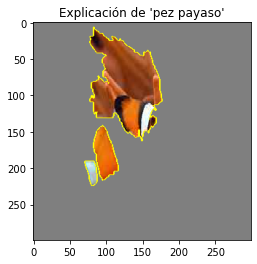

In [16]:
plt.figure()
plt.title("Explicación de 'pez payaso'")
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

### Visualización de la imagen completa, y segmentación de los superpíxeles que contribuyen positivamente a la predicción de la clase indicada
* Acá no se ocultan los superpixeles que no contribuyen a la clasificación indicada

In [17]:
temp, mask = explanation.get_image_and_mask(label = explanation.top_labels[0],
                                            positive_only=True, 
                                            num_features=5, 
                                            hide_rest=False)

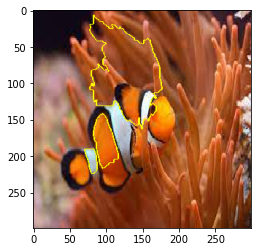

In [18]:
plt.figure()
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

### Visualización de superpíxeles que contribuyen positivamente a la predicción de la clase indicada
* Ahora consideramos un número mayor de superpíxeles para la explicación


In [19]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=False,
                                            num_features=10, 
                                            hide_rest=False)

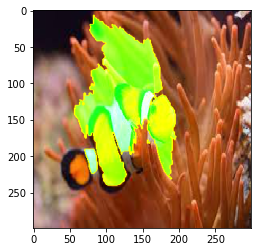

In [20]:
plt.figure()
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

### Visualización de los pesos en un mapa de calor
***
* explanation.local_exp es un diccionario de tamaño 6 (en este ejemplo), donde cada llave corresponde es una de las 6 clases, y su valor, es una lista que contiene los pesos de cada superpíxel.

In [21]:
#Selección de la clase, acá tomamos la primera clase indicada por el inception_v3
ind =  explanation.top_labels[0]

#Se asocia cada peso de la explicación a su superpixel correspondiente
dict_heatmap = dict(explanation.local_exp[ind])  # se toman los pesos de la clase ind
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) # se genera mapa de calor

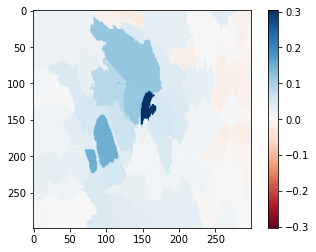

In [22]:
plt.figure()
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()
plt.show()

<div class="alert-success">
    <h2>Ejercicio 1</h2>
    <hr>
    <ul>
        <li> Considere ahora la imagen que está en el siguiente <a href="https://drive.google.com/drive/folders/1RP9mYlGoEXCaR0XemMH5LwWue8_buPpF?usp=sharing">link</a></li>
        <li>Genere la clasificación usando la CNN Inception V3 y explique (de acuerdo a los ejemplos anteriores) las cuatro primeras clasificaciones entregadas por la CNN.</li>
        <li>Analice la predicción genererada por el clasificador (puntaje/score) y las explicaciones para cada clase generada por LIME. Comente.</li>
    </ul>
</div>